In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from ast import literal_eval
import seaborn as sns
import seaborn.objects as so
sns.set_theme()

In [2]:
df = pd.read_parquet('/scratch/tsoares/wikidumps/simplewiki-NS0-20230901/val_data/test_data.parquet')
df['language'] = 'simple'
df

,source_title,source_ID,target_title,context,section,mention_present,source_lead,first_version,second_version,direct_match,missing_category,negative_contexts,language
0,Andouille,18,Taste,Andouille is a type of pork sausage. It is spi...,Lead,True,Andouille is a type of pork sausage. It is spi...,7592354,9074938,True,None,"[{'context': 'There are different kinds, all w...",simple
1,Andouille,18,Pecan,Andouille is a type of pork sausage. It is spi...,Lead,True,Andouille is a type of pork sausage. It is spi...,7592354,9074938,True,None,[{'context': 'Andouille is a type of pork saus...,simple
2,Andouille,18,Cane,Andouille is a type of pork sausage. It is spi...,Lead,True,Andouille is a type of pork sausage. It is spi...,7592354,9074938,True,None,[{'context': 'Andouille is a type of pork saus...,simple
3,Astronomy,48,Black_hole,Unsolved problems\nGreat discoveries also prod...,Unsolved problems,True,Astronomy is the scientific study of celestial...,9035453,9035459,True,None,"[{'context': ""Observational astronomy uses tel...",simple
4,Astronomy,48,Dark_matter,Galactic astronomers try to understand the str...,Subfields of astronomy,False,Astronomy is the scientific study of celestial...,9035250,9035453,False,missing_section,"[{'context': ""Observational astronomy uses tel...",simple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7815,Vik_%28disambiguation%29,1050954,Tr%C3%B8ndelag,"Vik, Grimstad, a village in Grimstad municipal...",Places,True,"Vik is a municipality in Vestland county, Norw...",9100723,9100724,True,None,[{'context': 'Vik is a municipality in Vestlan...,simple
7816,Vik_%28disambiguation%29,1050954,M%C3%B8re_og_Romsdal,"Vik, Rogaland, a village in Karmøy municipalit...",Places,True,"Vik is a municipality in Vestland county, Norw...",9100723,9100724,True,None,[{'context': 'Vik is a municipality in Vestlan...,simple
7817,Vik_%28disambiguation%29,1050954,Helsinki,"Places\nFinland\nViikki, a neighbourhood of He...",Places,True,"Vik is a municipality in Vestland county, Norw...",9100710,9100720,True,None,[{'context': 'Vik is a municipality in Vestlan...,simple
7818,Kvam,1051005,Innlandet,"Places\nNorway\nKvam, Vestland, a municipality...",Places,True,Kvam can be,9100893,9100896,True,None,"[{'context': 'People\nAdolph Kvam (1917-2006),...",simple


In [3]:
print(f"There are {len(df)} links in the test set.")

There are 7820 links in the test set.


In [4]:
print(f"Of these, it was not possible to extract a context from {len(df[df['context'] == ''])} ({len(df[df['context'] == ''])/len(df)*100:.2f}%) links.")
df = df[df['context'] != '']
print(f"We are left with {len(df)} links.")

Of these, it was not possible to extract a context from 861 (11.01%) links.
We are left with 6959 links.


## Plots

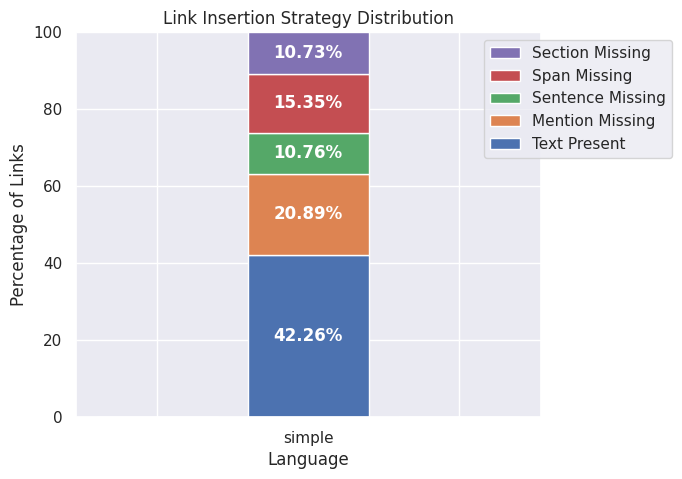

In [5]:
# matplotlib stacked bar plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Link Insertion Strategy Distribution')
ax.set_ylabel('Percentage of Links')
ax.set_xlabel('Language')
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(len(df['language'].unique())+2))
ax.set_xticklabels([''] + df['language'].unique().tolist() + [''], rotation=0)

present_text = [0]
missing_mention = [0]
missing_sentence = [0]
missing_span = [0]
missing_section = [0]

for language in df['language'].unique():
    present_text.append(len(df[(df['language'] == language) & (df['missing_category'].isna())]) / len(df[df['language'] == language]) * 100)
    missing_mention.append(len(df[(df['language'] == language) & (df['missing_category'] == 'missing_mention')]) / len(df[df['language'] == language]) * 100)
    missing_sentence.append(len(df[(df['language'] == language) & (df['missing_category'] == 'missing_sentence')]) / len(df[df['language'] == language]) * 100)
    missing_span.append(len(df[(df['language'] == language) & (df['missing_category'] == 'missing_span')]) / len(df[df['language'] == language]) * 100)
    missing_section.append(len(df[(df['language'] == language) & (df['missing_category'] == 'missing_section')]) / len(df[df['language'] == language]) * 100)

present_text.append(0)
missing_mention.append(0)
missing_sentence.append(0)
missing_span.append(0)
missing_section.append(0)
    
bottom = np.zeros(len(df['language'].unique())+2)
present_text = np.array(present_text)
missing_mention = np.array(missing_mention)
missing_sentence = np.array(missing_sentence)
missing_span = np.array(missing_span)
missing_section = np.array(missing_section)

ax.bar(np.arange(len(df['language'].unique())+2), present_text, label='Text Present', bottom=bottom)
bottom += present_text
ax.bar(np.arange(len(df['language'].unique())+2), missing_mention, label='Mention Missing', bottom=bottom)
bottom += missing_mention
ax.bar(np.arange(len(df['language'].unique())+2), missing_sentence, label='Sentence Missing', bottom=bottom)
bottom += missing_sentence
ax.bar(np.arange(len(df['language'].unique())+2), missing_span, label='Span Missing', bottom=bottom)
bottom += missing_span
ax.bar(np.arange(len(df['language'].unique())+2), missing_section, label='Section Missing', bottom=bottom)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
# flip order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(1.3, 1.0))

# add labels inside each bar
for i, v in enumerate(present_text):
    if v > 0:
        ax.text(i, v/2, f'{v:.2f}%', color='white', ha='center', va='center', fontweight='bold')
for i, v in enumerate(missing_mention):
    if v > 0:
        ax.text(i, present_text[i]+v/2, f'{v:.2f}%', color='white', ha='center', va='center', fontweight='bold')
for i, v in enumerate(missing_sentence):
    if v > 0:
        ax.text(i, present_text[i]+missing_mention[i]+v/2, f'{v:.2f}%', color='white', ha='center', va='center', fontweight='bold')
for i, v in enumerate(missing_span):
    if v > 0:
        ax.text(i, present_text[i]+missing_mention[i]+missing_sentence[i]+v/2, f'{v:.2f}%', color='white', ha='center', va='center', fontweight='bold')
for i, v in enumerate(missing_section):
    if v > 0:
        ax.text(i, present_text[i]+missing_mention[i]+missing_sentence[i]+missing_span[i]+v/2, f'{v:.2f}%', color='white', ha='center', va='center', fontweight='bold')

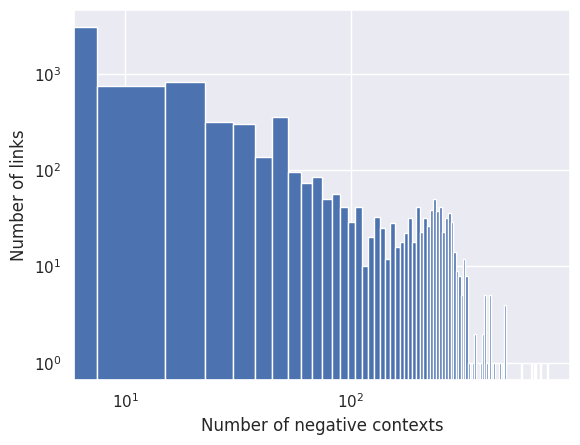

In [8]:
# plot a histogram with the number of negative contexts per link
negative_contexts = df[df['context'] != '']['negative_contexts'].reset_index(drop=True).apply(literal_eval).apply(len)
negative_contexts.hist(bins=100)
# set log x axis
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of negative contexts')
plt.ylabel('Number of links')
plt.show()

In [7]:
negative_contexts.describe()

count    6959.000000
mean       39.107918
std        71.785955
min         0.000000
25%         2.000000
50%        11.000000
75%        36.000000
max       750.000000
Name: negative_contexts, dtype: float64